# PREDICTING MICROBUSINESS DENSITY IN THE US
#### Ketan Kapse and Sai Abhishree Pappusetty

##### Please install the following libraries if not present.

In [60]:
#!pip install statsmodels
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install pmdarima


##### Importing the libraries and models

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

from functools import reduce
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from statsmodels.tsa.arima.model import ARIMA as ARIMA
from pmdarima.arima import auto_arima


In [4]:
os.chdir(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

##### Importing the training and test datasets into a pandas df

In [96]:
train = pd.read_csv('Data\\train.csv')
train["first_day_of_month"] = pd.to_datetime(train["first_day_of_month"])
train['first_day_of_month'] = train['first_day_of_month'].dt.strftime("%Y-%d-%m")
train = train.sort_values(['cfips','first_day_of_month']).reset_index(drop=True)

test = pd.read_csv('Data\\test.csv')
test["first_day_of_month"] = pd.to_datetime(test["first_day_of_month"])
test['first_day_of_month'] = test['first_day_of_month'].dt.strftime("%Y-%d-%m")
test = test.sort_values(['cfips','first_day_of_month']).reset_index(drop=True)


In [97]:
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [98]:
test.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-01-11
1,1001_2022-12-01,1001,2022-01-12
2,1001_2023-01-01,1001,2023-01-01
3,1001_2023-02-01,1001,2023-01-02
4,1001_2023-03-01,1001,2023-01-03


### Plotting Linear Models

In [115]:
def plotter(model_name, county):
     
    THRESHOLD = 0.15
    x_train = np.arange(39).reshape((-1,1))
    x_test = np.arange(38,47).reshape((-1,1))
    
    c = county
    df = train.loc[train.cfips==c]
    last = df.microbusiness_density.values[-1]
    
    model = model_name    
    model.fit(x_train,df.microbusiness_density)
    p = model.predict(x_train)
    
    err = p - df.microbusiness_density.values
    rng = df.microbusiness_density.max() - df.microbusiness_density.min()
    
    # Calculating the MAPE
    s = 0
    for k in range(39):
        e = np.abs( err[k] )
        r = e/rng 
        s += r
    s = s/39 
    
    p2 = model.predict(x_test)
    shift =  last - p2[0]
    if s<THRESHOLD: preds = p2[1:]+shift
    else: preds = [last]*8
    print("Mean Absolute Percentage Error: ", s)

    plt.figure(figsize=(20, 5))
    plt.plot(df.first_day_of_month,df.microbusiness_density,'-o',label='train data', color = 'gold')
    plt.plot(df.first_day_of_month,p,'-',label='regression', color = 'r')
    plt.plot(test.first_day_of_month.values[:8],preds,'--o',label='test pred')
    pre = ''; post=''
    if s>THRESHOLD: 
        pre=' Data does not show linear trends for\n'
        post=' (We will predict last train value)'
    else: 
        pre='Data shows linear trends. Using '+str(model_name)+' for\n'
    plt.title(f'{pre}CFIPS {c}{post}',size=18)
    plt.xticks(size = 8, rotation = 45)
    plt.xlabel('Date',size=16)
    plt.ylabel('Microbusiness Density',size=16)
    plt.legend()
    plt.show()
    
    plt.hist(err,bins=20,label='error')
    plt.plot([-rng/2,-rng/2],[0,10],'--',color='black',label='range')
    plt.plot([rng/2,rng/2],[0,10],'--',color='black')
    plt.xlim((-rng * 0.75,rng * 0.75))
    plt.legend()
    plt.title(f'\nTrain Error vs. Train Range. (avg={100*s:2.1f}%)',size=18)
    plt.show()
    print('\n\n\n\n\n\n')
    
        

In [75]:
### Defining Models

linReg = LinearRegression()
ridge = Ridge(alpha=2, random_state=42)
lasso = Lasso(alpha = 0.01, random_state=42)

Mean Absolute Percentage Error:  0.14710599523234363


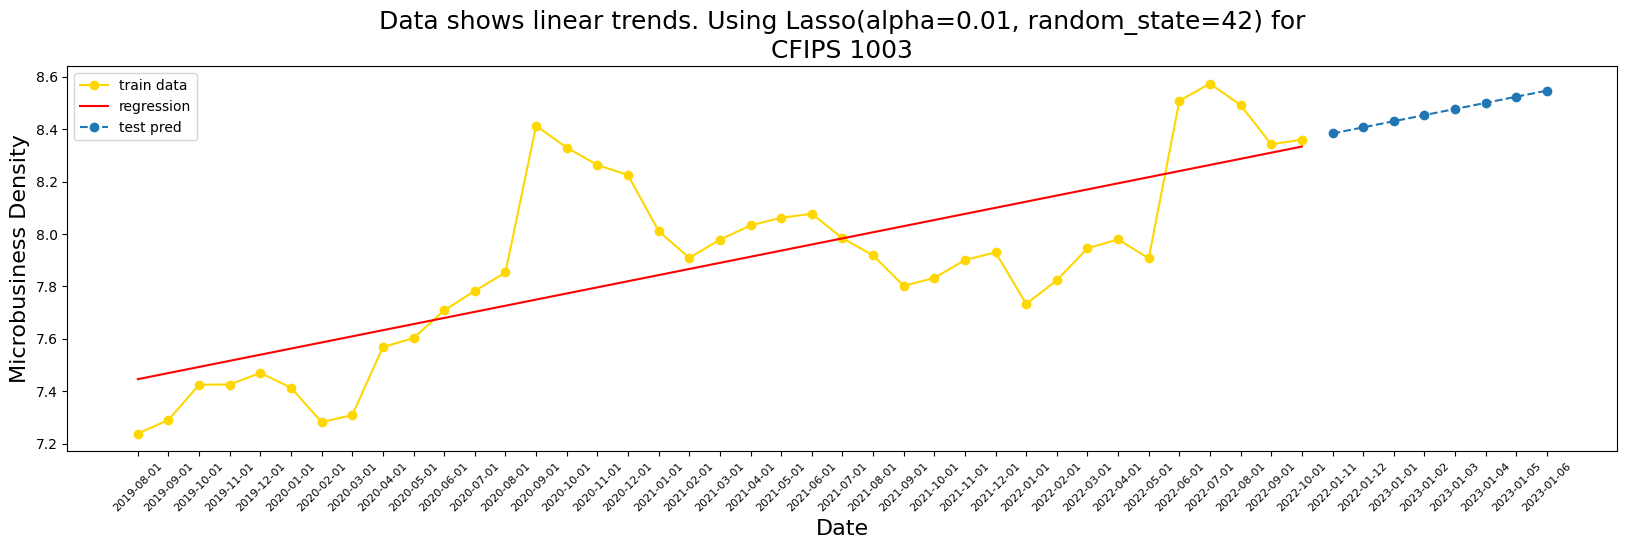

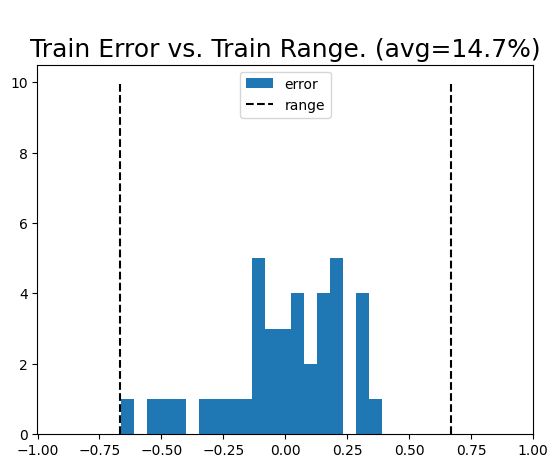

In [116]:
plotter(lasso, 1003)

Mean Absolute Percentage Error:  0.17495063329722152


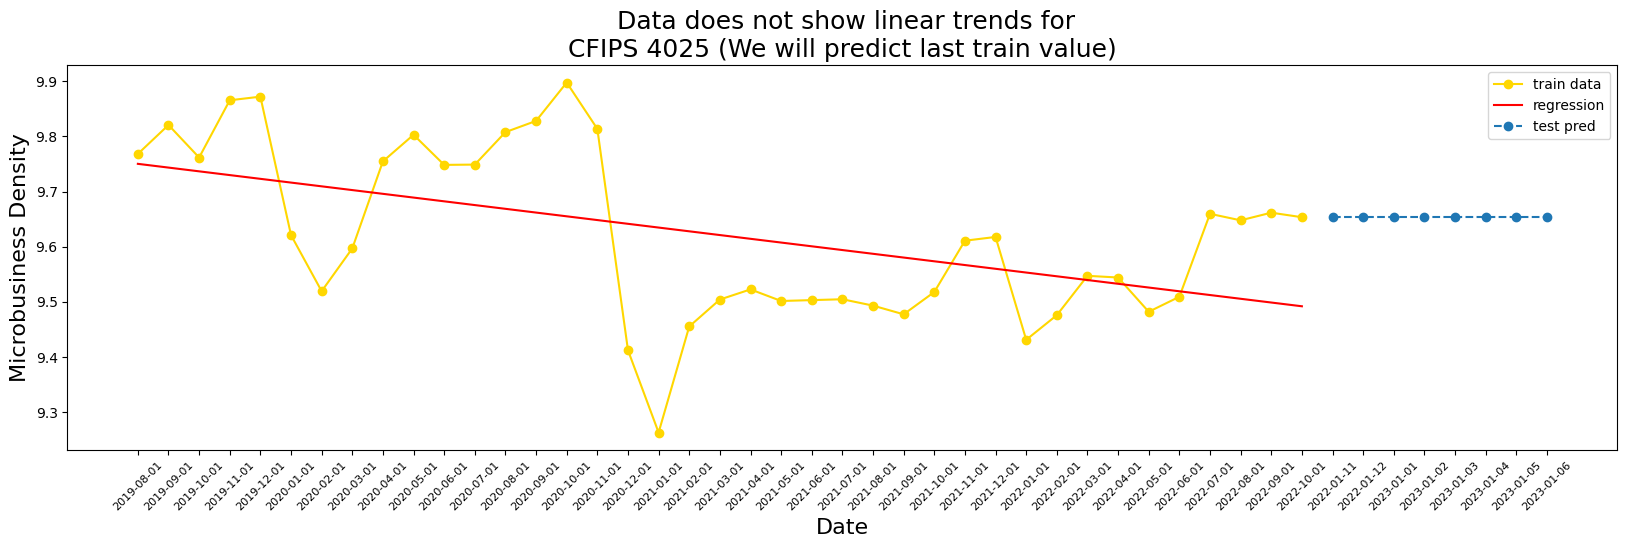

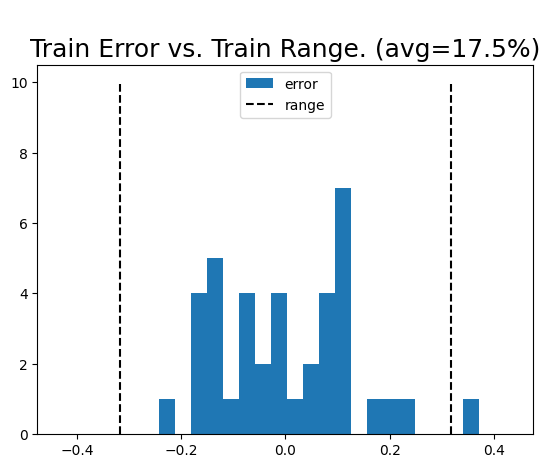

In [117]:
plotter(linReg, 4025)

Mean Absolute Percentage Error:  0.11432109411622528


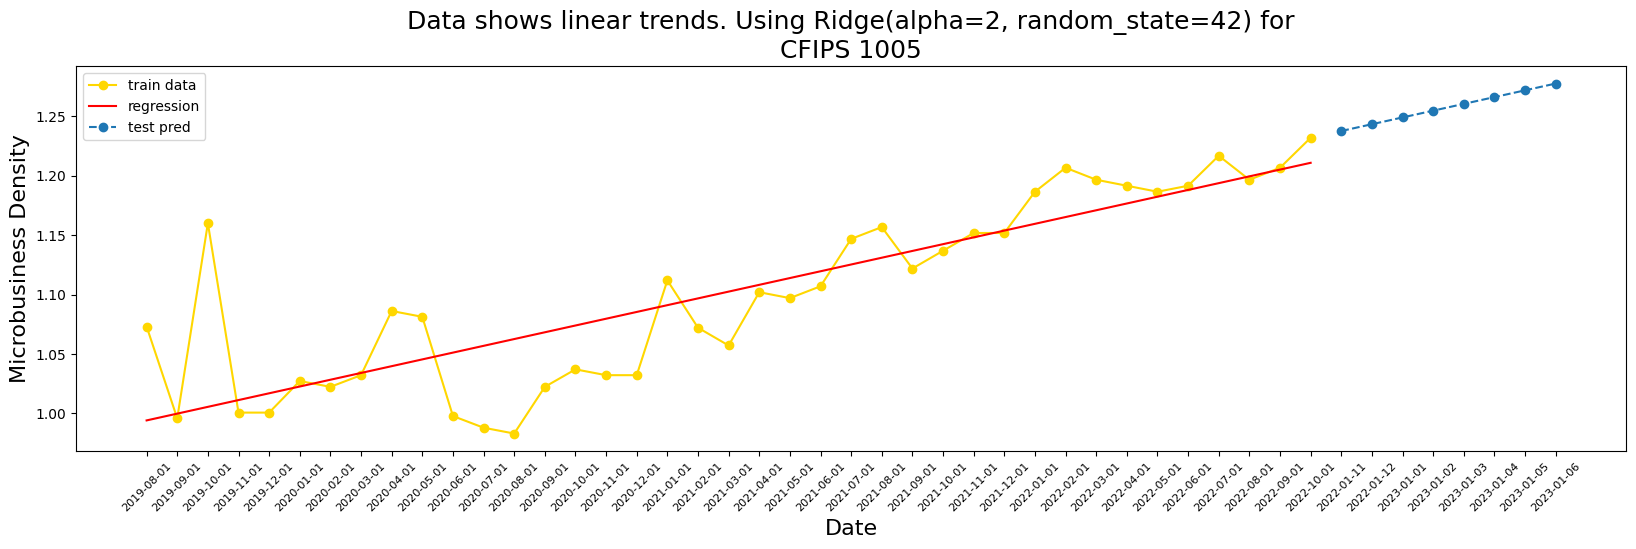

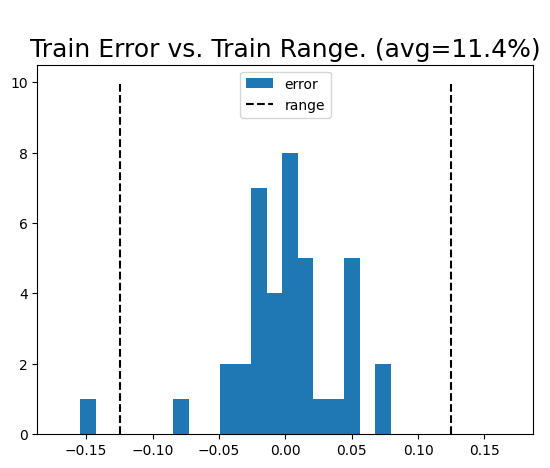

In [118]:
plotter(ridge, 1005)

##### Making predictions and storing them in a .csv file

In [42]:
def predictor(model_name, var_name):

    THRESHOLD = 0.15
    ACTIVE_THRESHOLD = 15_000     # we are considering counties with 15000 active businesses only

    IDS = train.cfips.unique()
    x_train = np.arange(39).reshape((-1,1))
    x_test = np.arange(38,47).reshape((-1,1))

    preds = np.zeros((len(IDS),8))
    last_preds = np.zeros((len(IDS),8))
    lin_trend = 0

    ct = 0
    for i,c in enumerate(IDS):
        df = train.loc[train.cfips==c]
        last = df.microbusiness_density.values[-1]
        active = df.active.values[-1]
        last_preds[i,] = [last]*8
        
        model = model_name
        model.fit(x_train,df.microbusiness_density)
        p = model.predict(x_train)
        err = p - df.microbusiness_density.values
        rng = df.microbusiness_density.max() - df.microbusiness_density.min()
        
        s = 0
        for k in range(39):
            e = np.abs( err[k] )
            r = e/rng 
            s += r
        s = s/39

        if (s>THRESHOLD)|(active<ACTIVE_THRESHOLD): 
            preds[i,] = [last]*8
            continue
        p2 = model.predict(x_test)
        shift =  last - p2[0]
        preds[i,] = p2[1:]+shift
        
        ct += 1
        lin_trend += 1
    test['microbusiness_density'] = preds.reshape((-1))
    sub = test[['row_id','microbusiness_density']]
    sub.rename(columns={'microbusiness_density': 'microbusiness_density_'+var_name}, inplace=True)
    sub.to_csv('submission_'+var_name+'.csv',index=False)
    

In [43]:
import warnings
warnings.filterwarnings('ignore')
predictor(linReg, 'Lin')
predictor(lasso, 'Lasso')
predictor(ridge, 'Ridge')

# Looking at AR, MA, ARMA and ARIMA models

In [45]:
trainStatDF = pd.read_csv('Data\\train.csv')
testStatDF = pd.read_csv('Data/test.csv')

In [46]:
trainStatDF.drop(['county', 'state' ,'row_id', 'active'], axis=1, inplace=True)
trainStatDF['first_day_of_month'] = pd.to_datetime(trainStatDF['first_day_of_month'])
trainStatDF = trainStatDF.groupby(['cfips', 'first_day_of_month']).sum()


In [47]:
trainStatDF.head()

microbusiness_density
cfips first_day_of_month                       
1001  2019-01-08                       3.007682
      2019-01-09                       2.884870
      2019-01-10                       3.055843
      2019-01-11                       2.993233
      2019-01-12                       2.993233

In [48]:
testStatDF.drop(['row_id'], axis= 1, inplace= True)
testStatDF['first_day_of_month'] = pd.to_datetime(testStatDF['first_day_of_month'])
testStatDF = testStatDF.groupby(['cfips', 'first_day_of_month']).sum()

In [49]:
testStatDF.head()

Empty DataFrame
Columns: []
Index: [(1001, 2022-11-01 00:00:00), (1001, 2022-12-01 00:00:00), (1001, 2023-01-01 00:00:00), (1001, 2023-02-01 00:00:00), (1001, 2023-03-01 00:00:00)]

In [50]:
model_test = ARIMA(trainStatDF.loc[1001,:],order = (0,0,0))
model_fit = model_test.fit()
print(model_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:     microbusiness_density   No. Observations:                   39
Model:                             ARIMA   Log Likelihood                  15.649
Date:                   Sun, 07 May 2023   AIC                            -27.297
Time:                           19:18:01   BIC                            -23.970
Sample:                                0   HQIC                           -26.104
                                    - 39                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1645      0.026    121.286      0.000       3.113       3.216
sigma2         0.0262      0.009      3.007      0.003       0.009       0.043
Ljung-Box (L1) (Q):         

# USING AUTO ARIMA TO GENERATE ORDERS FOR AR, MA, ARMA and ARIMA

In [65]:
# storing auto_arima generated orders in a pickle file.
### DONT EXECUTE AGAIN. TRAINING TIME IS AROUND 2 HOURS ON A 8 THREAD CPU!!!!! ###

dictionary  = {}

for i in tqdm(train['cfips'].unique()):
    history = [x[0] for x in trainStatDF.loc[i,:].values]
    dictionary[i] = [auto_arima(history, test = 'adf',seasonal = False).order]

with open('auto_arima_orders.pkl','wb') as f:
    pickle.dump(dictionary,f)


100%|██████████| 3135/3135 [1:43:32<00:00,  1.98s/it]  


In [80]:
with open('auto_arima_orders.pkl', 'rb') as file:  
    dictionary = pickle.load(file)

In [81]:
dictionary

{1001: [(1, 0, 0)],
 1003: [(2, 2, 0)],
 1005: [(0, 1, 1)],
 1007: [(0, 2, 3)],
 1009: [(1, 0, 0)],
 1011: [(0, 2, 1)],
 1013: [(3, 2, 0)],
 1015: [(0, 2, 1)],
 1017: [(0, 2, 2)],
 1019: [(2, 2, 2)],
 1021: [(1, 2, 1)],
 1023: [(0, 1, 0)],
 1025: [(0, 1, 1)],
 1027: [(3, 2, 0)],
 1029: [(0, 1, 1)],
 1031: [(0, 2, 2)],
 1033: [(0, 2, 1)],
 1035: [(2, 2, 0)],
 1037: [(0, 2, 1)],
 1039: [(2, 1, 1)],
 1041: [(0, 2, 2)],
 1043: [(0, 2, 1)],
 1045: [(0, 1, 0)],
 1047: [(1, 2, 1)],
 1049: [(0, 2, 1)],
 1051: [(1, 2, 1)],
 1053: [(0, 2, 1)],
 1055: [(0, 2, 1)],
 1057: [(2, 2, 0)],
 1059: [(0, 2, 1)],
 1061: [(0, 1, 1)],
 1063: [(0, 1, 0)],
 1065: [(0, 1, 0)],
 1067: [(1, 2, 2)],
 1069: [(0, 2, 3)],
 1071: [(3, 2, 1)],
 1073: [(2, 1, 2)],
 1075: [(0, 1, 0)],
 1077: [(0, 1, 0)],
 1079: [(0, 2, 1)],
 1081: [(2, 2, 1)],
 1083: [(2, 0, 0)],
 1085: [(0, 2, 1)],
 1087: [(0, 2, 1)],
 1089: [(3, 2, 1)],
 1091: [(0, 1, 1)],
 1093: [(1, 2, 1)],
 1095: [(0, 1, 1)],
 1097: [(1, 0, 0)],
 1099: [(0, 2, 1)],


##### Making some fits based on the orders generated by auto_arima
order = (p,d,q)
AR = (p,0,0)
MA = (0, 0, q)
ARMA = (p, 0, q)
ARIMA = (p, d, q)

In [51]:
model_test = ARIMA(trainStatDF.loc[1045,:],order = (1,0,0)) # AR
model_fit = model_test.fit()
print(model_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:     microbusiness_density   No. Observations:                   39
Model:                    ARIMA(1, 0, 0)   Log Likelihood                  58.163
Date:                   Sun, 07 May 2023   AIC                           -110.326
Time:                           19:19:51   BIC                           -105.335
Sample:                                0   HQIC                          -108.535
                                    - 39                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5714      0.149     10.517      0.000       1.279       1.864
ar.L1          0.9521      0.123      7.751      0.000       0.711       1.193
sigma2         0.0028      0

In [54]:
model_test = ARIMA(trainStatDF.loc[6101,:],order = (0,0,1)) #MA
model_fit = model_test.fit()
print(model_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:     microbusiness_density   No. Observations:                   39
Model:                    ARIMA(0, 0, 1)   Log Likelihood                  38.532
Date:                   Sun, 07 May 2023   AIC                            -71.064
Time:                           19:23:37   BIC                            -66.073
Sample:                                0   HQIC                           -69.273
                                    - 39                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6149      0.031    115.879      0.000       3.554       3.676
ma.L1          0.5825      0.114      5.105      0.000       0.359       0.806
sigma2         0.0080      0

In [55]:
model_test = ARIMA(trainStatDF.loc[13035,:],order = (2,0,2)) # ARMA
model_fit = model_test.fit()
print(model_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:     microbusiness_density   No. Observations:                   39
Model:                    ARIMA(2, 0, 2)   Log Likelihood                  48.061
Date:                   Sun, 07 May 2023   AIC                            -84.123
Time:                           19:24:55   BIC                            -74.141
Sample:                                0   HQIC                           -80.541
                                    - 39                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2063      0.070     45.628      0.000       3.069       3.344
ar.L1          1.3350      0.264      5.048      0.000       0.817       1.853
ar.L2         -0.5008      0

In [56]:
model_test = ARIMA(trainStatDF.loc[13081,:],order = (3,2,1)) #ARIMA
model_fit = model_test.fit()
print(model_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:     microbusiness_density   No. Observations:                   39
Model:                    ARIMA(3, 2, 1)   Log Likelihood                  68.786
Date:                   Sun, 07 May 2023   AIC                           -127.572
Time:                           19:26:16   BIC                           -119.517
Sample:                                0   HQIC                          -124.732
                                    - 39                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2980      0.236     -1.261      0.207      -0.761       0.165
ar.L2         -0.4169      0.204     -2.039      0.041      -0.818      -0.016
ar.L3         -0.3539      0

##### MAKING PREDICTIONS USING THE AR MODEL

In [72]:
testStatDF['microbusiness_density'] = 0

In [84]:
df_AR = train[['first_day_of_month', 'microbusiness_density','cfips']].copy(deep = True)
df_AR['Date'] = pd.to_datetime(df_AR['first_day_of_month'])
df_AR = df_AR.drop(columns = 'first_day_of_month')

df_AR = df_AR.groupby(['cfips','Date']).sum()
df_AR.head()

microbusiness_density
cfips Date                             
1001  2019-01-08               3.007682
      2019-01-09               2.884870
      2019-01-10               3.055843
      2019-01-11               2.993233
      2019-01-12               2.993233

In [83]:
df_AR_test = test.copy(deep = True)
df_AR_test['Date'] = pd.to_datetime(df_AR_test['first_day_of_month'])
df_AR_test = df_AR_test.drop(columns = 'first_day_of_month')

df_AR_test = df_AR_test.groupby(['cfips','Date']).sum()
df_AR_test.head()

row_id
cfips Date                       
1001  2022-11-01  1001_2022-11-01
      2022-12-01  1001_2022-12-01
      2023-01-01  1001_2023-01-01
      2023-02-01  1001_2023-02-01
      2023-03-01  1001_2023-03-01

In [101]:
df_AR_test['microbusiness_density'] = 0

for i in tqdm(train['cfips'].unique()):
    history_f = [x[0] for x in df_AR.loc[int(i),:].values]
    f1 = []

    for t in range(len(df_AR_test.loc[int(i),:])):

        model = ARIMA(history_f, order = (dictionary[i][0][0],0,0)) # AR
        output = model_fit.forecast()[0]

        history_f.append(output)
        f1.append(output)

    for j in range(len(f1)):
        df_AR_test.loc[int(i), 'microbusiness_density'] = f1[j]

df_AR_test.index = range(0,len(test))

  0%|          | 2/3135 [00:01<28:26,  1.84it/s]c:\Users\ketan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  0%|          | 4/3135 [00:01<21:03,  2.48it/s]c:\Users\ketan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  0%|          | 8/3135 [00:03<24:56,  2.09it/s]c:\Users\ketan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  0%|          | 11/3135 [00:05<25:58,  2.00it/s]c:\Users\ketan\AppData\Local\Programs\Pyth

There are many counties for which the AR model does not converge on even with the best orders generated by the Auto ARIMA. This is observed on the other models as well. Possible solution is to use other models on these counties.

In [110]:
sample = pd.read_csv('Data/sample_submission.csv')

Storing the results in a .csv file

In [117]:
submission = pd.DataFrame({'row_id':sample['row_id'],'microbusiness_density_AR': 0})
df_AR_Test_row_id = list(df_AR_test['row_id'])

for i in range(len(submission['row_id'])):
    index = df_AR_Test_row_id.index(submission.iloc[i,0])
    submission.iloc[i,1] = df_AR_test.iloc[index,1]

submission.to_csv('submission_AR.csv',index = False)
submission

,row_id,microbusiness_density_AR
0,1001_2022-11-01,3.360348
1,1003_2022-11-01,8.065785
2,1005_2022-11-01,1.102516
3,1007_2022-11-01,1.270829
4,1009_2022-11-01,1.808938
...,...,...
25075,56037_2023-06-01,3.119987
25076,56039_2023-06-01,26.340934
25077,56041_2023-06-01,3.946924
25078,56043_2023-06-01,2.989260


#### We will now do the same with MA

In [112]:
df_MA = train[['first_day_of_month', 'microbusiness_density','cfips']].copy(deep = True)
df_MA['Date'] = pd.to_datetime(df_MA['first_day_of_month'])
df_MA = df_MA.drop(columns = 'first_day_of_month')
df_MA = df_MA.groupby(['cfips','Date']).sum()

df_MA_test = test.copy(deep = True)
df_MA_test['Date'] = pd.to_datetime(df_MA_test['first_day_of_month'])
df_MA_test = df_MA_test.drop(columns = 'first_day_of_month')
df_MA_test = df_MA_test.groupby(['cfips','Date']).sum()


row_id
cfips Date                       
1001  2022-11-01  1001_2022-11-01
      2022-12-01  1001_2022-12-01
      2023-01-01  1001_2023-01-01
      2023-02-01  1001_2023-02-01
      2023-03-01  1001_2023-03-01

In [114]:
df_MA_test['microbusiness_density'] = 0

for i in tqdm(train['cfips'].unique()):
    history_f = [x[0] for x in df_MA.loc[int(i),:].values]
    f1 = []

    for t in range(len(df_MA_test.loc[int(i),:])):

        model = ARIMA(history_f, order = (0,0,dictionary[i][0][2])) # MA
        model_fit = model.fit()

        output = model_fit.forecast()[0]

        history_f.append(output)
        f1.append(output)

    for j in range(len(f1)):
        df_MA_test.loc[int(i), 'microbusiness_density'] = f1[j]

df_MA_test.index = range(0,len(test))

  0%|          | 3/3135 [00:01<20:58,  2.49it/s]c:\Users\ketan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ketan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ketan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  0%|          | 5/3135 [00:03<40:00,  1.30it/s]c:\Users\ketan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

In [116]:
submission_MA = pd.DataFrame({'row_id':sample['row_id'],'microbusiness_density_MA': 0})
MA_row_id = list(df_MA_test['row_id'])

for i in range(len(submission_MA['row_id'])):
    index = MA_row_id.index(submission_MA.iloc[i,0])
    submission_MA.iloc[i,1] = df_MA_test.iloc[index,1]

submission_MA.to_csv('submission_MA.csv',index = False)
submission_MA

,row_id,microbusiness_density_MA
0,1001_2022-11-01,3.164529
1,1003_2022-11-01,7.889805
2,1005_2022-11-01,1.105190
3,1007_2022-11-01,1.271876
4,1009_2022-11-01,1.676946
...,...,...
25075,56037_2023-06-01,3.108745
25076,56039_2023-06-01,26.337930
25077,56041_2023-06-01,3.959509
25078,56043_2023-06-01,2.901744


### USING ARMA

In [118]:
df_ARMA = train[['first_day_of_month', 'microbusiness_density','cfips']].copy(deep = True)
df_ARMA['Date'] = pd.to_datetime(df_ARMA['first_day_of_month'])
df_ARMA = df_ARMA.drop(columns = 'first_day_of_month')
df_ARMA = df_ARMA.groupby(['cfips','Date']).sum()

df_ARMA_test = test.copy(deep = True)
df_ARMA_test['Date'] = pd.to_datetime(df_ARMA_test['first_day_of_month'])
df_ARMA_test = df_ARMA_test.drop(columns = 'first_day_of_month')
df_ARMA_test = df_ARMA_test.groupby(['cfips','Date']).sum()


In [149]:
df_ARMA_test['microbusiness_density'] = 0

for i in tqdm(train['cfips'].unique()):
    history_f = [x[0] for x in df_ARMA.loc[int(i),:].values]
    f1 = []

    for t in range(len(df_ARMA_test.loc[int(i),:])):

        model = ARIMA(history_f, order = (dictionary[i][0][0],0,dictionary[i][0][2])) # ARMA
        model_fit = model.fit()

        output = model_fit.forecast()[0]

        history_f.append(output)
        f1.append(output)

    for j in range(len(f1)):
        df_ARMA_test.loc[int(i), 'microbusiness_density'] = f1[j]

df_ARMA_test.index = range(0,len(test))

  0%|          | 3/3135 [00:01<32:36,  1.60it/s]c:\Users\ketan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ketan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ketan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  0%|          | 4/3135 [00:03<54:56,  1.05s/it]c:\Users\ketan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

In [150]:
submission_ARMA = pd.DataFrame({'row_id':sample['row_id'],'microbusiness_density_ARMA': 0})
ARMA_row_id = list(df_ARMA_test['row_id'])

for i in range(len(submission_MA['row_id'])):
    index = ARMA_row_id.index(submission_ARMA.iloc[i,0])
    submission_ARMA.iloc[i,1] = df_MA_test.iloc[index,1]

submission_ARMA.to_csv('submission_ARMA.csv',index = False)
submission_ARMA

,row_id,microbusiness_density_ARMA
0,1001_2022-11-01,3.164529
1,1003_2022-11-01,7.889805
2,1005_2022-11-01,1.105190
3,1007_2022-11-01,1.271876
4,1009_2022-11-01,1.676946
...,...,...
25075,56037_2023-06-01,3.108745
25076,56039_2023-06-01,26.337930
25077,56041_2023-06-01,3.959509
25078,56043_2023-06-01,2.901744


### ARIMA MODEL

In [175]:
df_ARIMA = train[['first_day_of_month', 'microbusiness_density','cfips']].copy(deep = True)
df_ARIMA['Date'] = pd.to_datetime(df_ARIMA['first_day_of_month'])
df_ARIMA = df_ARIMA.drop(columns = 'first_day_of_month')
df_ARIMA = df_ARIMA.groupby(['cfips','Date']).sum()

df_ARIMA_test = test.copy(deep = True)
df_ARIMA_test['Date'] = pd.to_datetime(df_ARIMA_test['first_day_of_month'])
df_ARIMA_test = df_ARIMA_test.drop(columns = 'first_day_of_month')
df_ARIMA_test = df_ARIMA_test.groupby(['cfips','Date']).sum()


In [176]:
df_ARIMA_test['microbusiness_density'] = 0

for i in tqdm(train['cfips'].unique()):
    history_f = [x[0] for x in df_ARIMA.loc[int(i),:].values]
    f1 = []

    for t in range(len(df_ARIMA_test.loc[int(i),:])):

        model = ARIMA(history_f, order = dictionary[i][0]) # ARMA
        model_fit = model.fit()

        output = model_fit.forecast()[0]

        history_f.append(output)
        f1.append(output)

    for j in range(len(f1)):
        df_ARIMA_test.loc[int(i), 'microbusiness_density'] = f1[j]

df_ARIMA_test.index = range(0,len(test))

  0%|          | 2/3135 [00:00<23:52,  2.19it/s]c:\Users\ketan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  0%|          | 3/3135 [00:01<28:00,  1.86it/s]c:\Users\ketan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  0%|          | 4/3135 [00:03<1:01:04,  1.17s/it]c:\Users\ketan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  0%|          | 7/3135 [00:05<40:03,  1.30it/s]  c:\Users\ketan\AppData\Local\Programs\P

In [177]:
submission_ARIMA = pd.DataFrame({'row_id':sample['row_id'],'microbusiness_density_ARIMA': 0})
ARIMA_row_id = list(df_ARIMA_test['row_id'])

for i in range(len(submission_ARIMA['row_id'])):
    index = ARIMA_row_id.index(submission_ARIMA.iloc[i,0])
    submission_ARIMA.iloc[i,1] = df_ARIMA_test.iloc[index,1]

submission_ARIMA.to_csv('submission_ARIMA.csv',index = False)
submission_ARIMA

,row_id,microbusiness_density_ARIMA
0,1001_2022-11-01,3.360348
1,1003_2022-11-01,7.947281
2,1005_2022-11-01,1.215692
3,1007_2022-11-01,1.262021
4,1009_2022-11-01,1.808938
...,...,...
25075,56037_2023-06-01,2.812261
25076,56039_2023-06-01,27.465612
25077,56041_2023-06-01,4.069946
25078,56043_2023-06-01,3.243920


Making a merged.csv file that contains all the predictions made by the 7 models.

In [185]:
df1 = pd.read_csv('submission_AR.csv')
df2 = pd.read_csv('submission_MA.csv')
df3 = pd.read_csv('submission_ARMA.csv')
df4 = pd.read_csv('submission_ARIMA.csv')
df5 = pd.read_csv('submissionLin.csv')
df6 = pd.read_csv('submissionLasso.csv')
df7 = pd.read_csv('submissionRidge.csv')
data_frames = [df1, df2, df3, df4, df5, df6, df7]


In [192]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['row_id'],
                                            how='outer'), data_frames)
df_merged.to_csv('merged.csv', index = False)